In [ ]:
# Install necessary packages
!pip install opendatasets hickle

import opendatasets as od
import os

# Download dataset
od.download("https://www.kaggle.com/datasets/karthiknm1/ucsd-anomaly-detection-dataset")

# Check if the data is downloaded successfully
if os.path.exists("/content/ucsd-anomaly-detection-dataset"):
    print("Dataset downloaded successfully.")
else:
    print("Failed to download dataset.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 6.6 MB/s eta 0:00:00
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ayushaiml
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/karthiknm1/ucsd-anomaly-detection-dataset


100%|██████████| 702M/702M [00:40<00:00, 18.1MB/s]



Dataset downloaded successfully.


In [ ]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from PIL import Image
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import cv2
import os

In [ ]:
# Load a subset of images from a directory
def load_images_from_directory(directory, target_size=(128, 128), grayscale=False, load_fraction=0.3):
    images = []
    labels = []
    total_files = []

    # Gather all files from the directory
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif', 'tif', 'tiff')):
                total_files.append(os.path.join(root, file))

    # Calculate the number of files to load
    num_files_to_load = int(len(total_files) * load_fraction)
    files_to_load = np.random.choice(total_files, num_files_to_load, replace=False)

    # Load the selected files
    for img_path in files_to_load:
        try:
            if grayscale:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print(f"Error loading image {img_path}: Image is None")
                    continue
                img = cv2.resize(img, target_size)
                img = np.expand_dims(img, axis=-1)  # Add a channel dimension
            else:
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
                img = tf.keras.preprocessing.image.img_to_array(img)
            img = img / 255.0
            images.append(img)
            label = 0 if 'Train' in root else 1  # Simple logic to assign labels
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    return np.array(images), np.array(labels)

In [ ]:
# Define directories
normal_dir = "/content/ucsd-anomaly-detection-dataset/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train"
anomaly_dir = "/content/ucsd-anomaly-detection-dataset/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test"


In [ ]:
# Load images (30% of the total data)
normal_images, normal_labels = load_images_from_directory(normal_dir, target_size=(128, 128), load_fraction=0.3)
anomaly_images, anomaly_labels = load_images_from_directory(anomaly_dir, target_size=(128, 128), load_fraction=0.3)


print(f"Number of normal images loaded: {len(normal_images)}")
print(f"Normal Images shape: {normal_images.shape}")
print(f"Normal Labels shape: {normal_labels.shape}")
print(f"Number of anomaly images loaded: {len(anomaly_images)}")
print(f"Anomaly Images shape: {anomaly_images.shape}")
print(f"Anomaly Labels shape: {anomaly_labels.shape}")

Number of normal images loaded: 2040
Normal Images shape: (2040, 128, 128, 3)
Normal Labels shape: (2040,)
Number of anomaly images loaded: 2760
Anomaly Images shape: (2760, 128, 128, 3)
Anomaly Labels shape: (2760,)


In [ ]:
# Combine normal and anomaly images
all_images = np.concatenate([normal_images, anomaly_images], axis=0)
all_labels = np.concatenate([normal_labels, anomaly_labels], axis=0)

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(all_images, all_labels, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:
# Define Neural Network Models
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_shape = (128, 128, 3)
cnn_model = create_cnn_model(input_shape)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

cnn_history = cnn_model.fit(X_train, y_train,
                            validation_data=(X_val, y_val),
                            epochs=10, callbacks=[early_stopping])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - accuracy: 0.5871 - loss: 0.7544 - val_accuracy: 0.7771 - val_loss: 0.5028
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7665 - loss: 0.4848 - val_accuracy: 0.8156 - val_loss: 0.4020
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8197 - loss: 0.3909 - val_accuracy: 0.8073 - val_loss: 0.4211
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8588 - loss: 0.3291 - val_accuracy: 0.9000 - val_loss: 0.2570
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9161 - loss: 0.2136 - val_accuracy: 0.9229 - val_loss: 0.2072
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9271 - loss: 0.1775 - val_accuracy: 0.9344 - val_loss: 0.1770
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9587 - loss: 0.1194 - val_accuracy: 0.9438 - val_loss: 0.1492
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9667 - loss: 0.0909 - val_accuracy: 0.9531 -

In [ ]:
# Define ANN Model
def create_ann_model(input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

ann_model = create_ann_model(input_shape)

ann_history = ann_model.fit(X_train, y_train,
                            validation_data=(X_val, y_val),
                            epochs=10, callbacks=[early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5438 - loss: 6.0847 - val_accuracy: 0.5885 - val_loss: 0.6430
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5850 - loss: 0.6709 - val_accuracy: 0.5885 - val_loss: 0.6155
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5799 - loss: 0.6392 - val_accuracy: 0.5885 - val_loss: 0.6095


In [ ]:
# Define MLP Model
def create_mlp_model(input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

mlp_model = create_mlp_model(input_shape)

mlp_history = mlp_model.fit(X_train, y_train,
                            validation_data=(X_val, y_val),
                            epochs=10, callbacks=[early_stopping])

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.5280 - loss: 9.5971 - val_accuracy: 0.5885 - val_loss: 0.6664
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5626 - loss: 0.6886 - val_accuracy: 0.5885 - val_loss: 0.6306
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5747 - loss: 0.6341 - val_accuracy: 0.5885 - val_loss: 0.6125


In [ ]:
# Evaluate the Models
cnn_val_loss, cnn_val_acc = cnn_model.evaluate(X_val, y_val)
print("CNN Validation Accuracy:", cnn_val_acc)

cnn_test_loss, cnn_test_acc = cnn_model.evaluate(X_test, y_test)
print("CNN Test Accuracy:", cnn_test_acc)

ann_val_loss, ann_val_acc = ann_model.evaluate(X_val, y_val)
print("ANN Validation Accuracy:", ann_val_acc)

ann_test_loss, ann_test_acc = ann_model.evaluate(X_test, y_test)
print("ANN Test Accuracy:", ann_test_acc)

mlp_val_loss, mlp_val_acc = mlp_model.evaluate(X_val, y_val)
print("MLP Validation Accuracy:", mlp_val_acc)

mlp_test_loss, mlp_test_acc = mlp_model.evaluate(X_test, y_test)
print("MLP Test Accuracy:", mlp_test_acc)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9668 - loss: 0.1236
CNN Validation Accuracy: 0.9583333134651184
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9422 - loss: 0.1637
CNN Test Accuracy: 0.9447916746139526
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5885 - loss: 0.6490
ANN Validation Accuracy: 0.5885416865348816
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5356 - loss: 0.6432
ANN Test Accuracy: 0.5479166507720947
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5885 - loss: 0.6703
MLP Validation Accuracy: 0.5885416865348816
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5356 - loss: 0.6645
MLP Test Accuracy: 0.5479166507720947


In [ ]:
# Isolation Forest
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.1)
iso_forest.fit(X_train.reshape((X_train.shape[0], -1)))
y_pred_iso = iso_forest.predict(X_test.reshape((X_test.shape[0], -1)))
y_pred_iso = [0 if x == 1 else 1 for x in y_pred_iso]  # Convert to binary labels

print("Isolation Forest Accuracy:", accuracy_score(y_test, y_pred_iso))
print("Classification Report:\n", classification_report(y_test, y_pred_iso))

Isolation Forest Accuracy: 0.475
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.91      0.61       434
           1       0.61      0.11      0.19       526

    accuracy                           0.48       960
   macro avg       0.54      0.51      0.40       960
weighted avg       0.54      0.47      0.38       960



In [ ]:
# Local Outlier Factor (LOF)
from sklearn.neighbors import LocalOutlierFactor

# Flatten images for LOF
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred_lof = lof.fit_predict(X_test_flat)
y_pred_lof = [0 if x == 1 else 1 for x in y_pred_lof]

print("Local Outlier Factor Accuracy:", accuracy_score(y_test, y_pred_lof))
print("Classification Report:\n", classification_report(y_test, y_pred_lof))


Local Outlier Factor Accuracy: 0.5083333333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.95      0.64       434
           1       0.78      0.14      0.24       526

    accuracy                           0.51       960
   macro avg       0.63      0.55      0.44       960
weighted avg       0.64      0.51      0.42       960



In [ ]:
# One-Class SVM
from sklearn.svm import OneClassSVM

one_class_svm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.03)
one_class_svm.fit(X_train_flat)
y_pred_svm = one_class_svm.predict(X_test_flat)
y_pred_svm = [0 if x == 1 else 1 for x in y_pred_svm]

print("One-Class SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

One-Class SVM Accuracy: 0.45416666666666666
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.97      0.62       434
           1       0.54      0.03      0.05       526

    accuracy                           0.45       960
   macro avg       0.49      0.50      0.34       960
weighted avg       0.50      0.45      0.31       960



In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
import numpy as np
from sklearn.metrics import accuracy_score

# Define Autoencoder Model
def create_autoencoder(input_shape):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    # Change the number of output channels to 3 to match input
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

# Example usage
input_shape = (128, 128, 3)  # Update with your image dimensions
autoencoder = create_autoencoder(input_shape)

# Train the autoencoder on normal images
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_data=(X_val, X_val))

# Use the autoencoder to predict and compute reconstruction errors
reconstructed_images = autoencoder.predict(X_test)
reconstruction_errors = np.mean(np.abs(X_test - reconstructed_images), axis=(1, 2, 3))

# Use reconstruction errors for anomaly detection
threshold = np.percentile(reconstruction_errors, 95)  # Example threshold
anomalies = reconstruction_errors > threshold

# Assuming y_test contains true labels (0 for normal, 1 for anomaly)
y_pred = anomalies.astype(int) # Convert boolean anomalies to 0 and 1
accuracy = accuracy_score(y_test, y_pred)
print("Number of anomalies detected:", np.sum(anomalies))
print("Accuracy:", accuracy)

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.6451 - val_loss: 0.5171
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.5147 - val_loss: 0.5123
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.5150 - val_loss: 0.5100
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.5050 - val_loss: 0.5091
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.5147 - val_loss: 0.5083
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.5056 - val_loss: 0.5078
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.5017 - val_loss: 0.5074
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.5104 - val_loss: 0.5071
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.5021 - val_loss: 0.5069
Epoch 10/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.5071 - val_loss: 0.5067
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Number of anomalies detected: 48
Accuracy: 0.44166666666666665


# Visualization

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from torchvision import models, transforms
from torch import nn
import torch
import matplotlib.pyplot as plt
from PIL import Image

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 115MB/s]


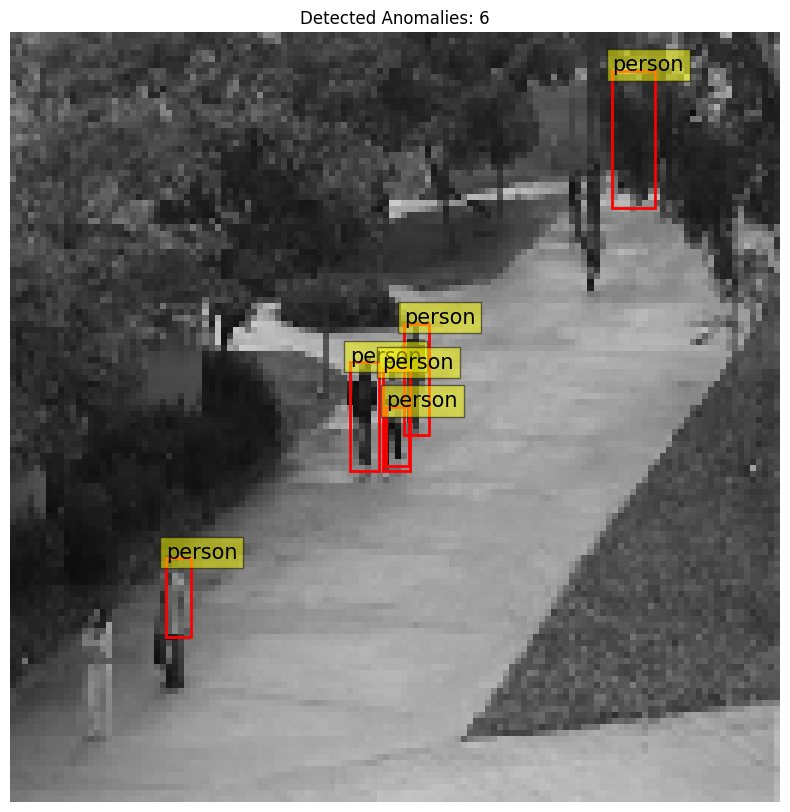

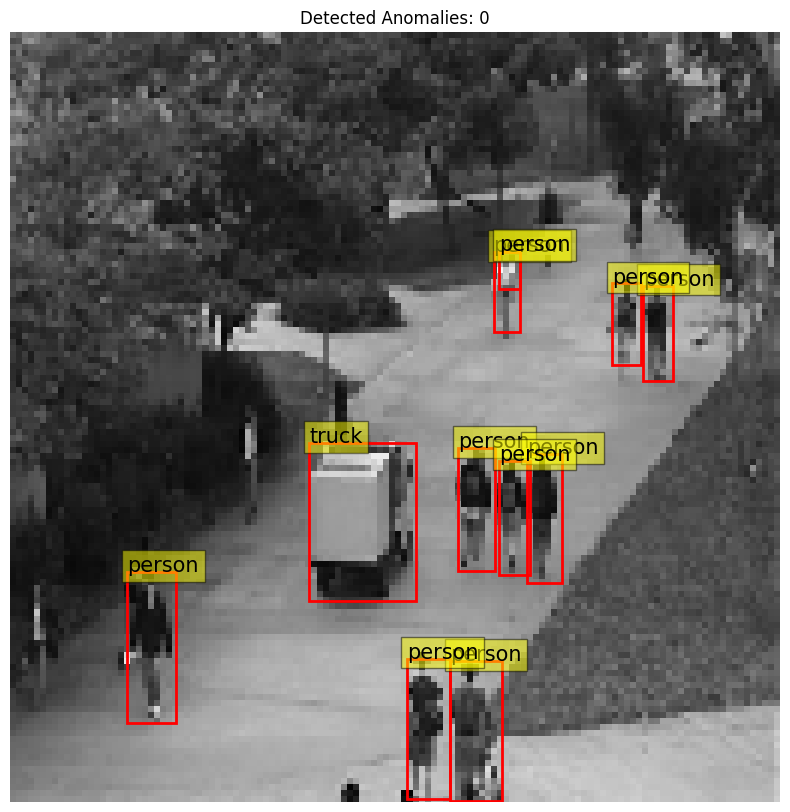

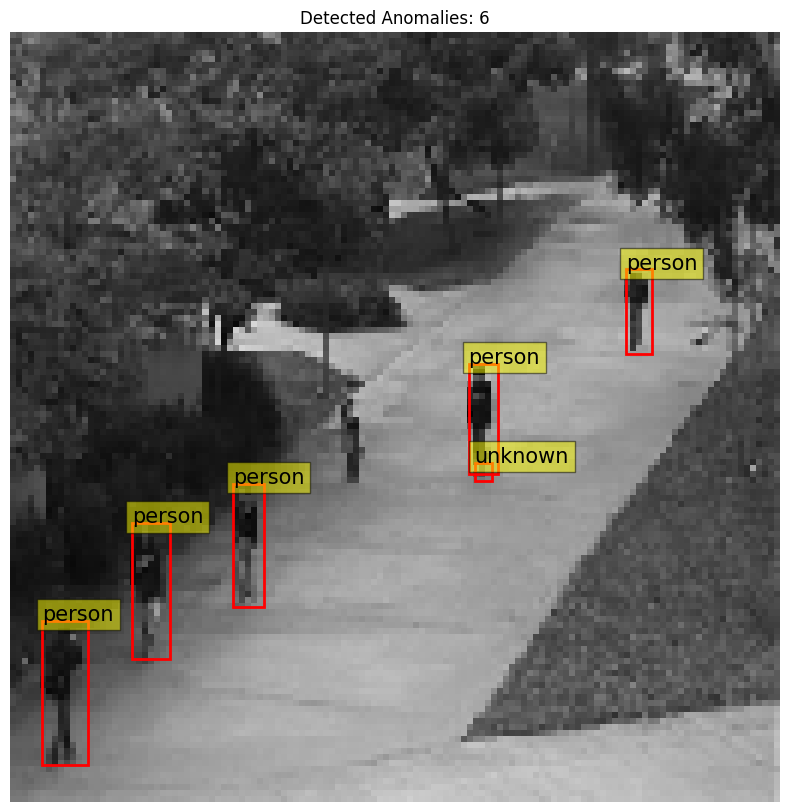

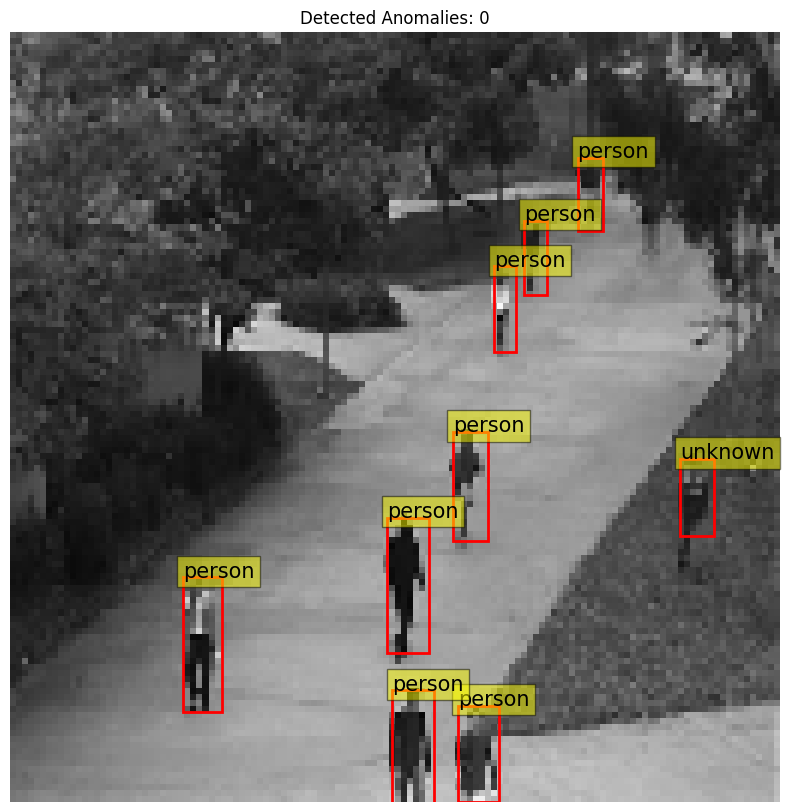

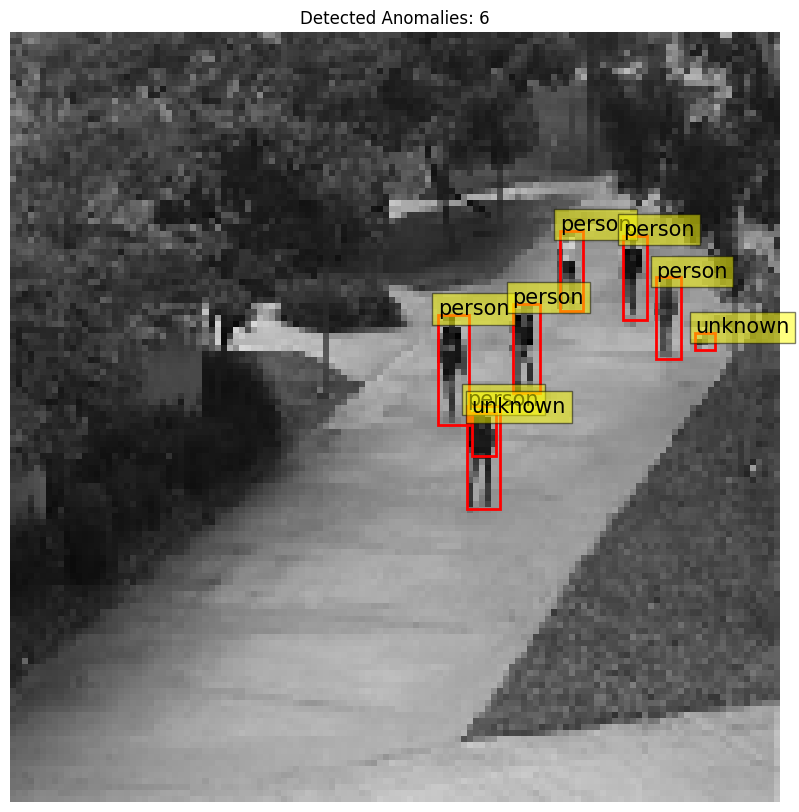

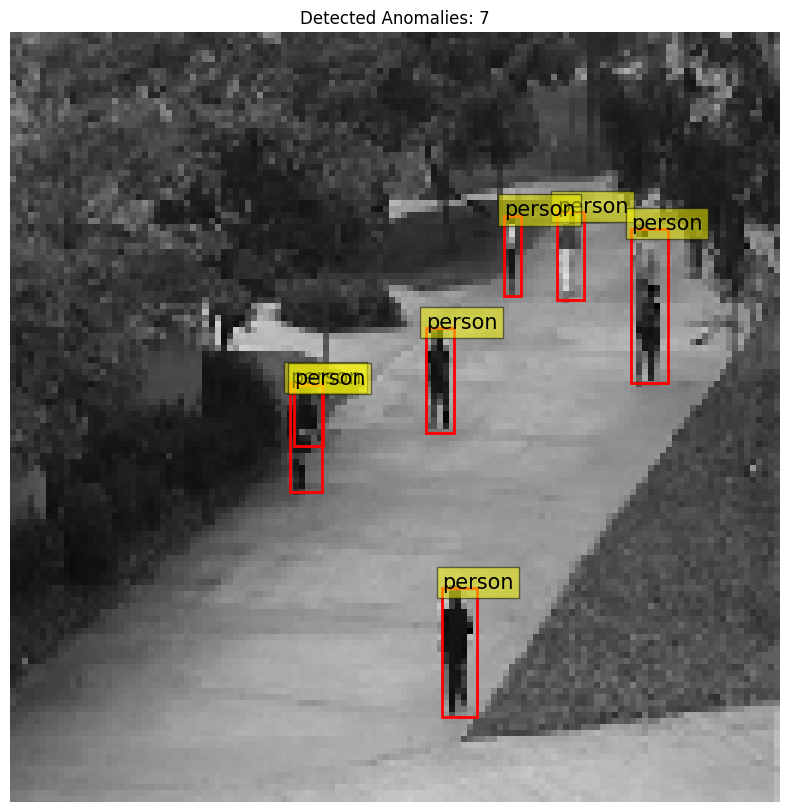

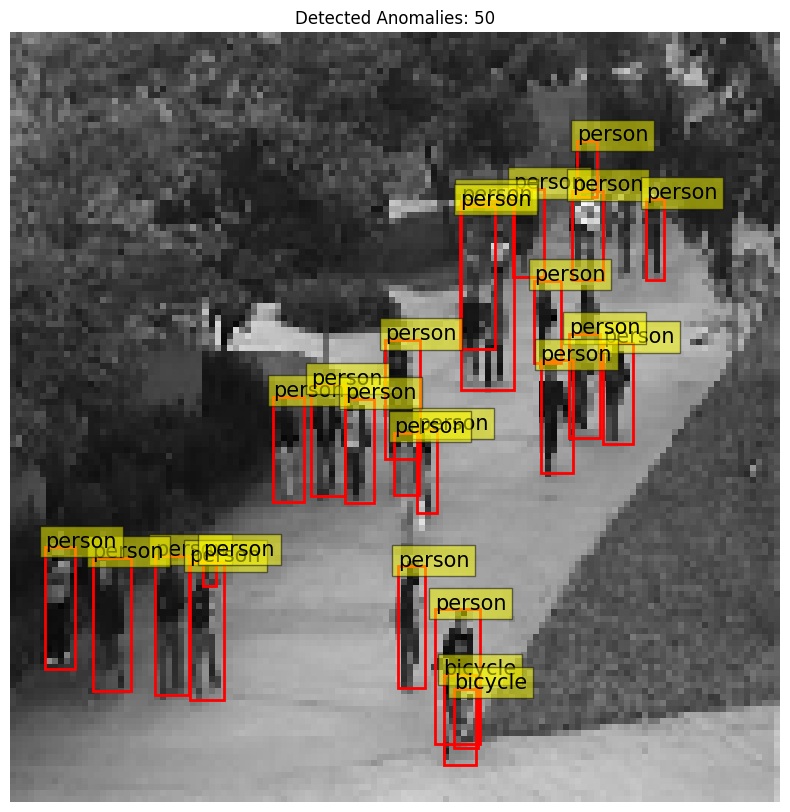

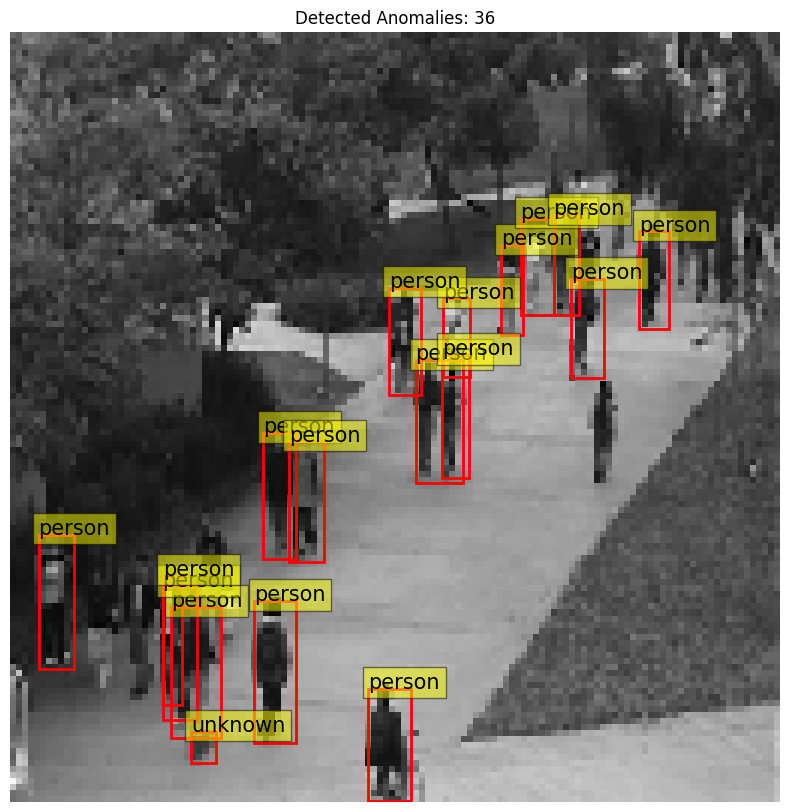

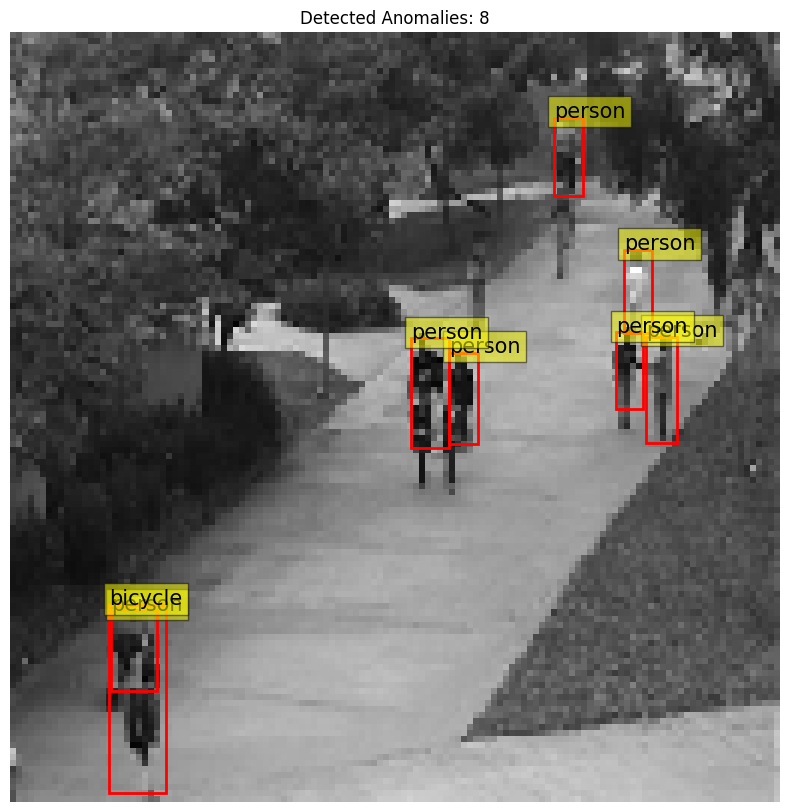

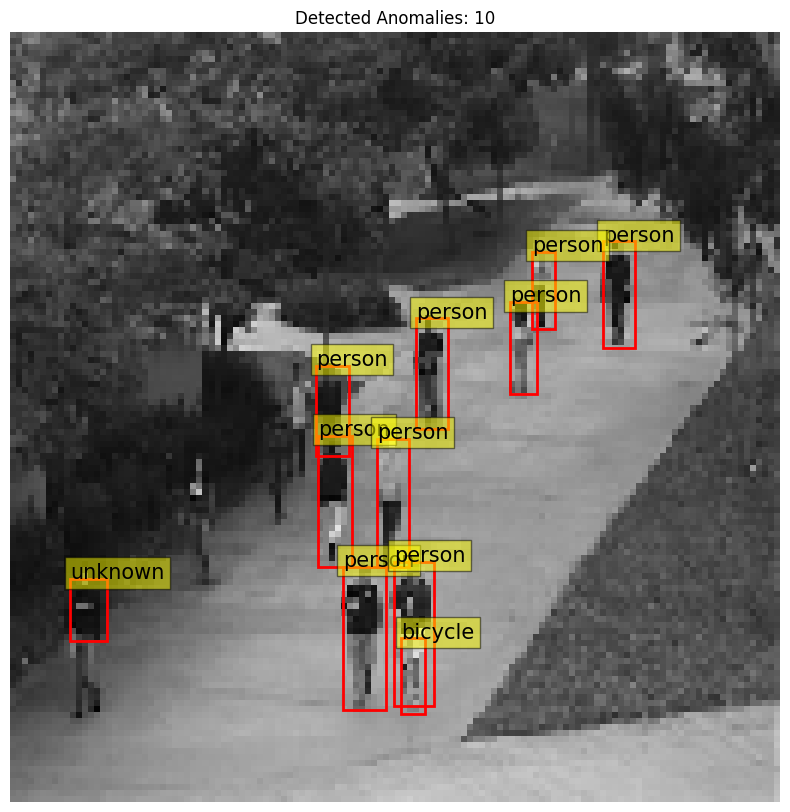

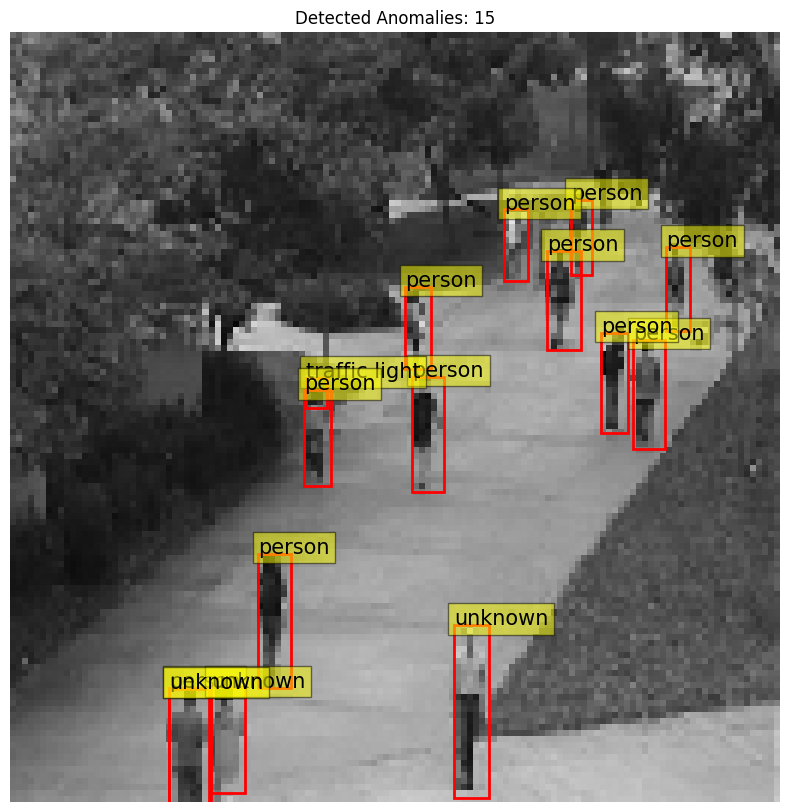

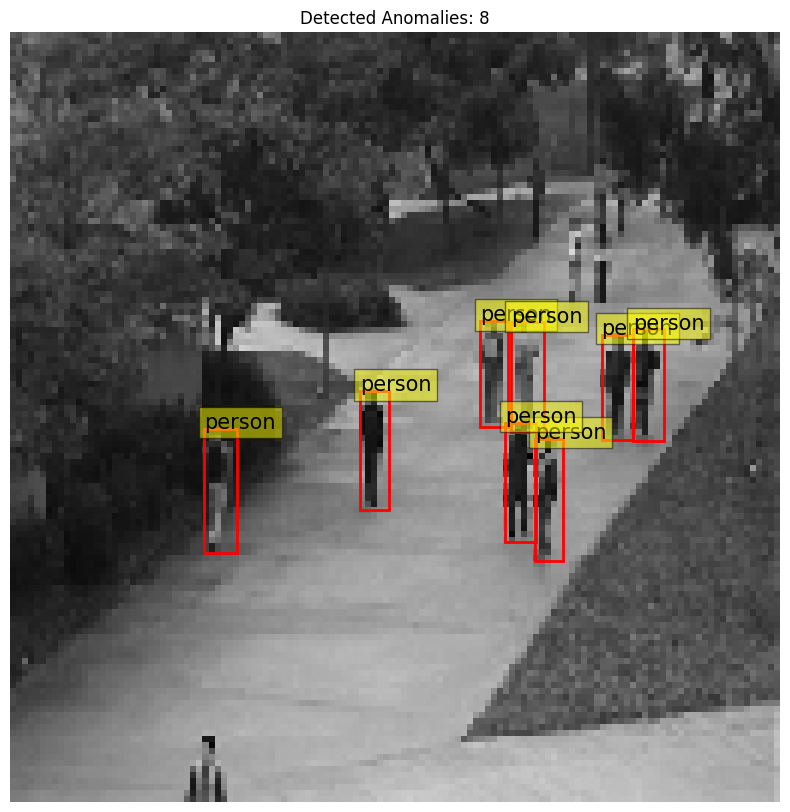

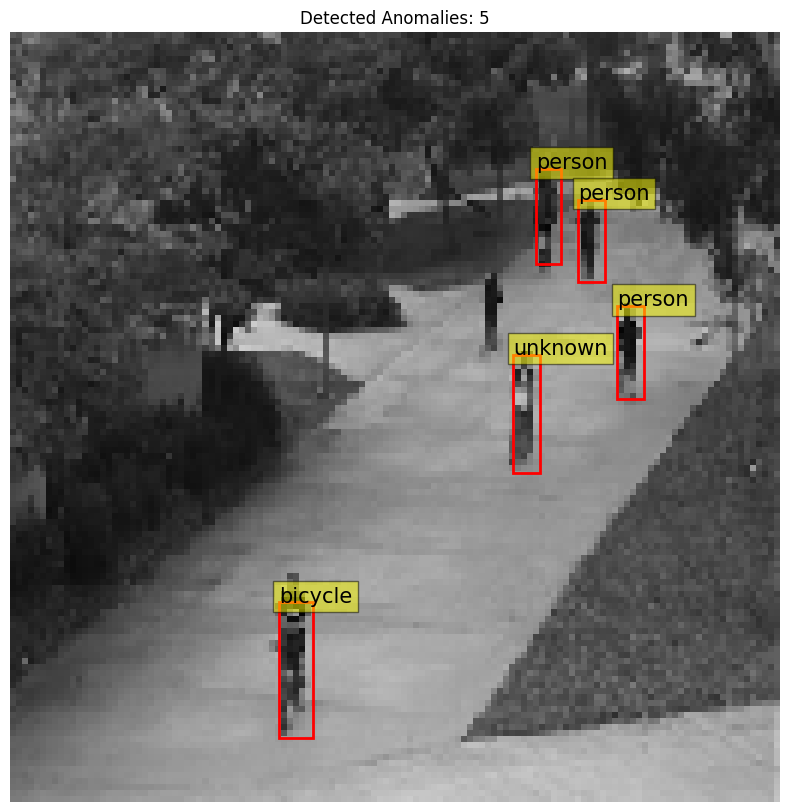

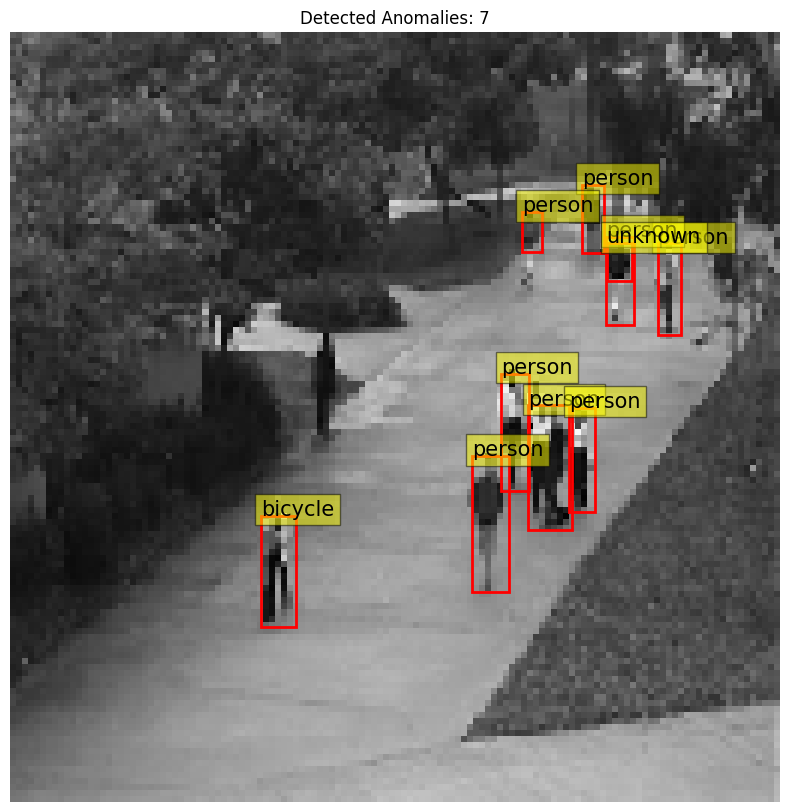

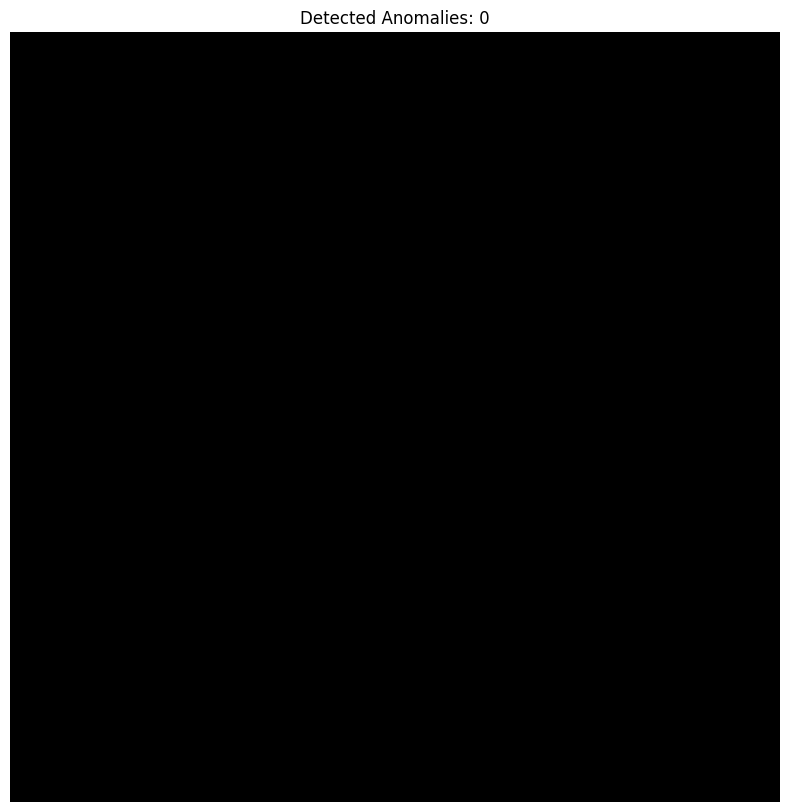

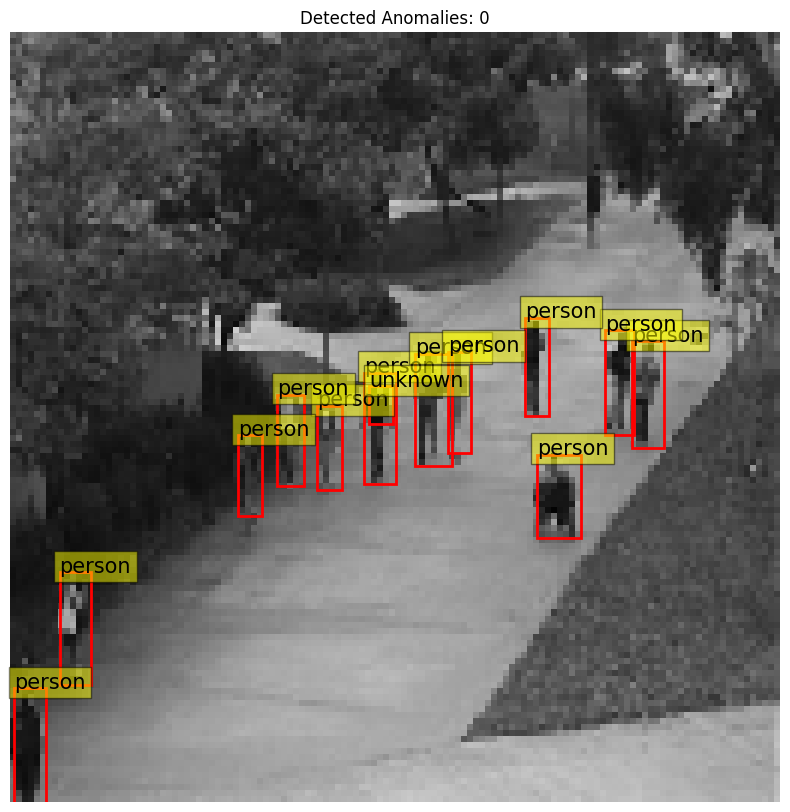

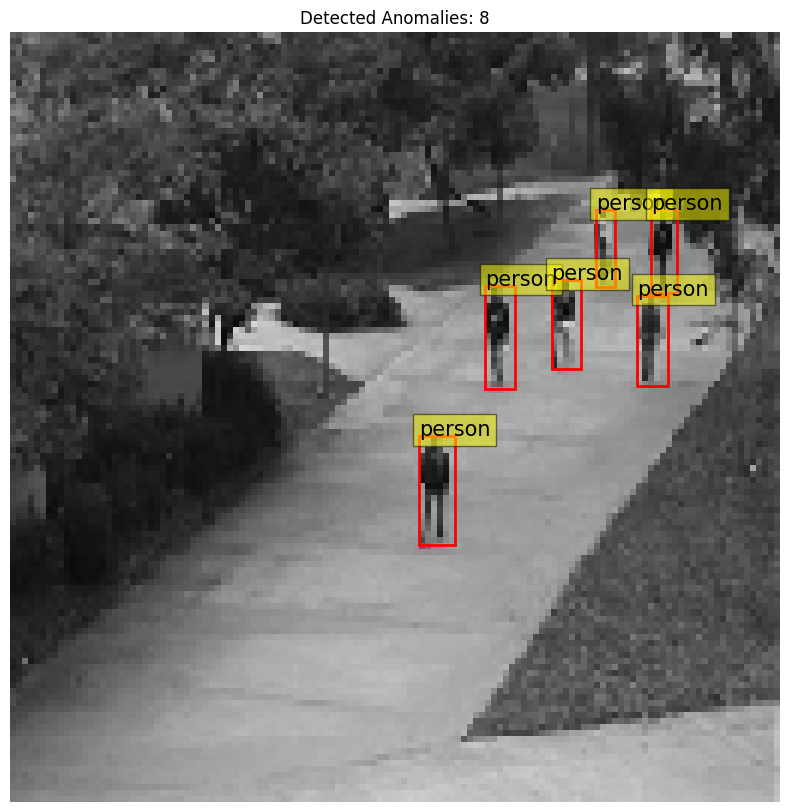

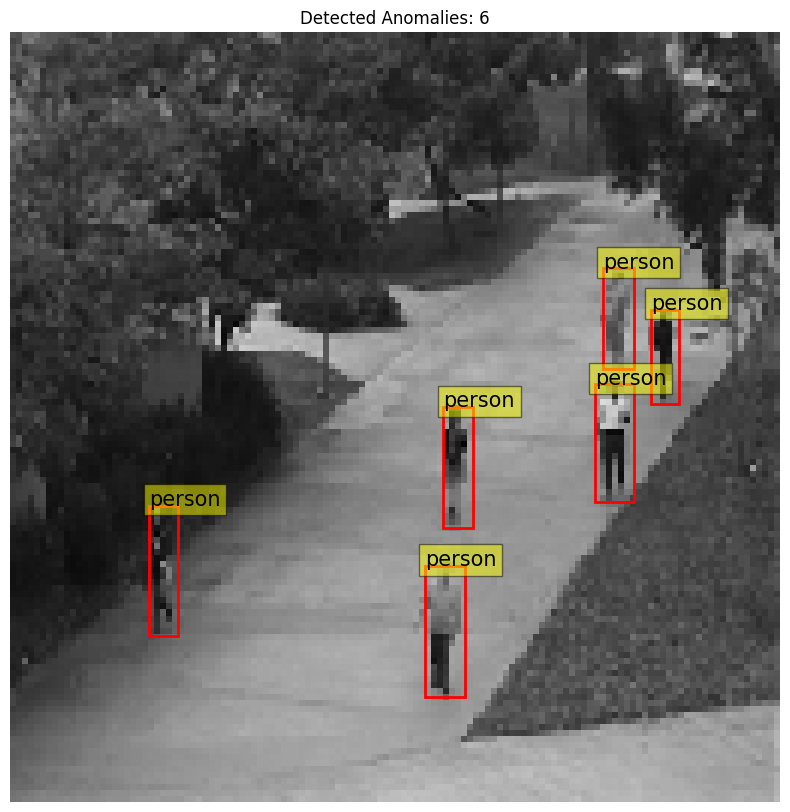

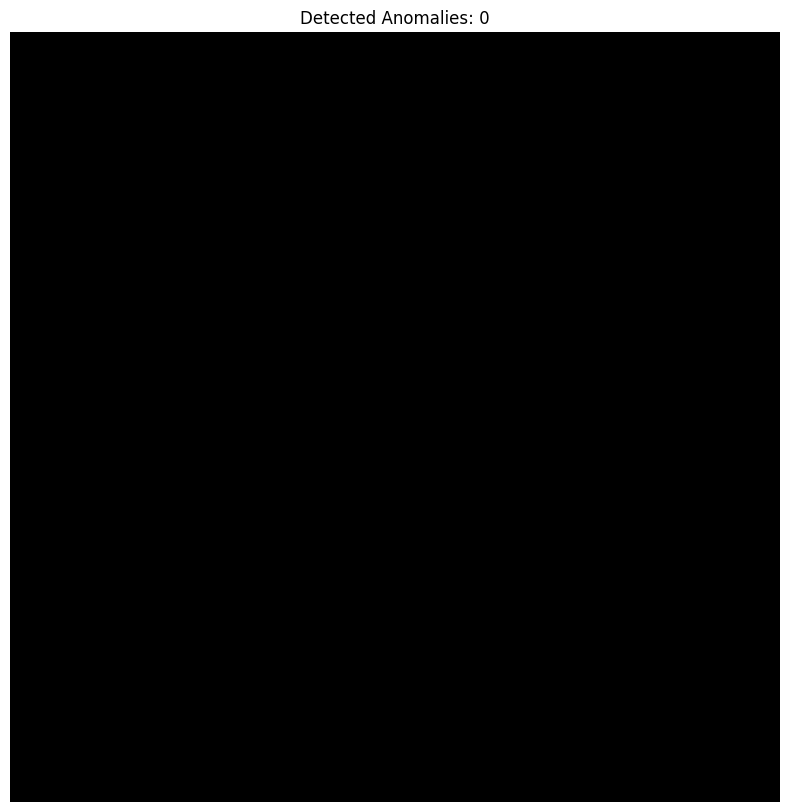

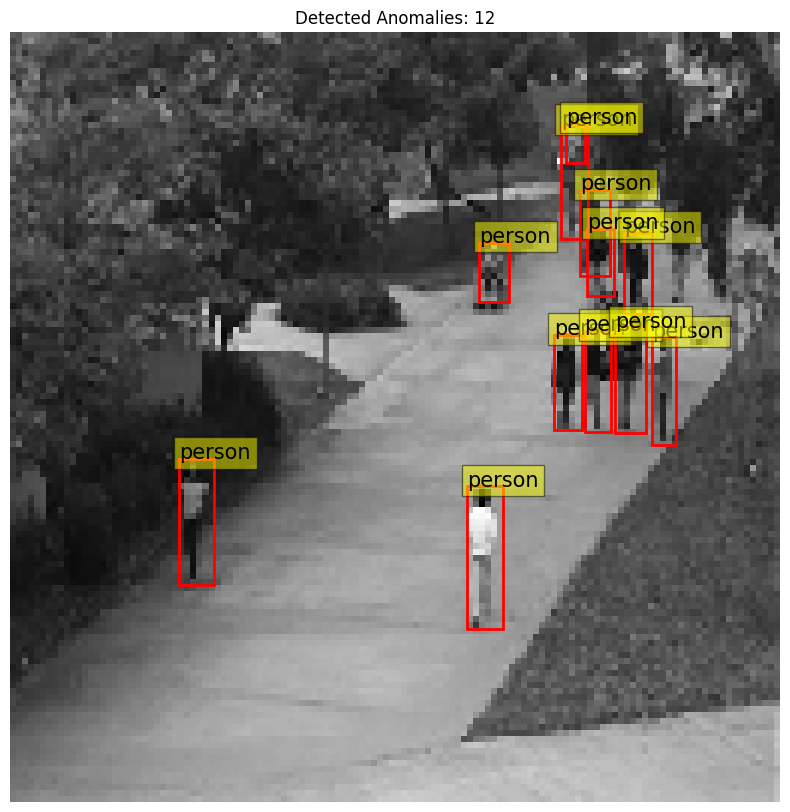

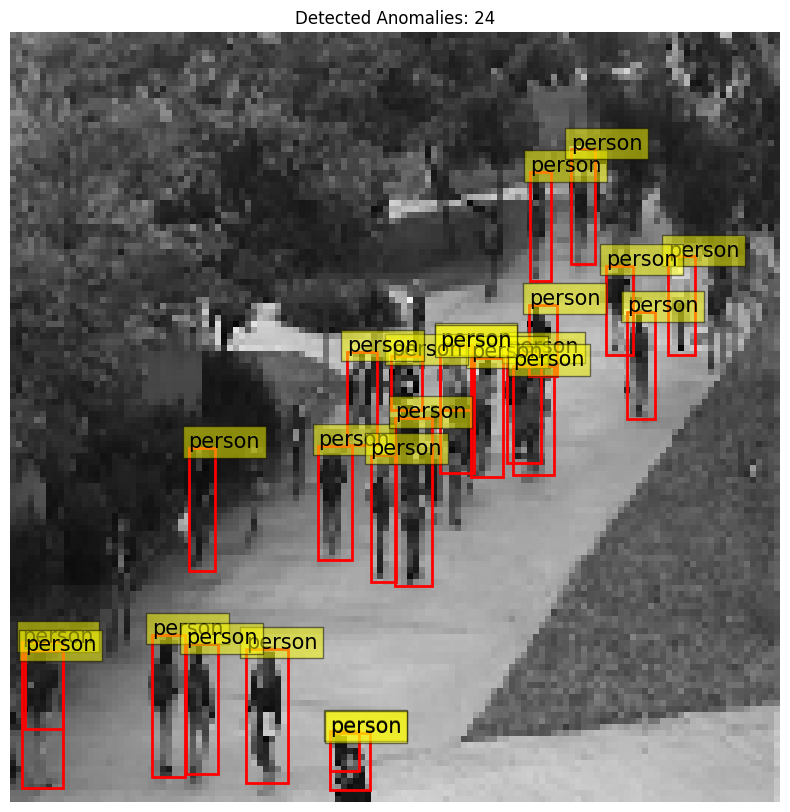

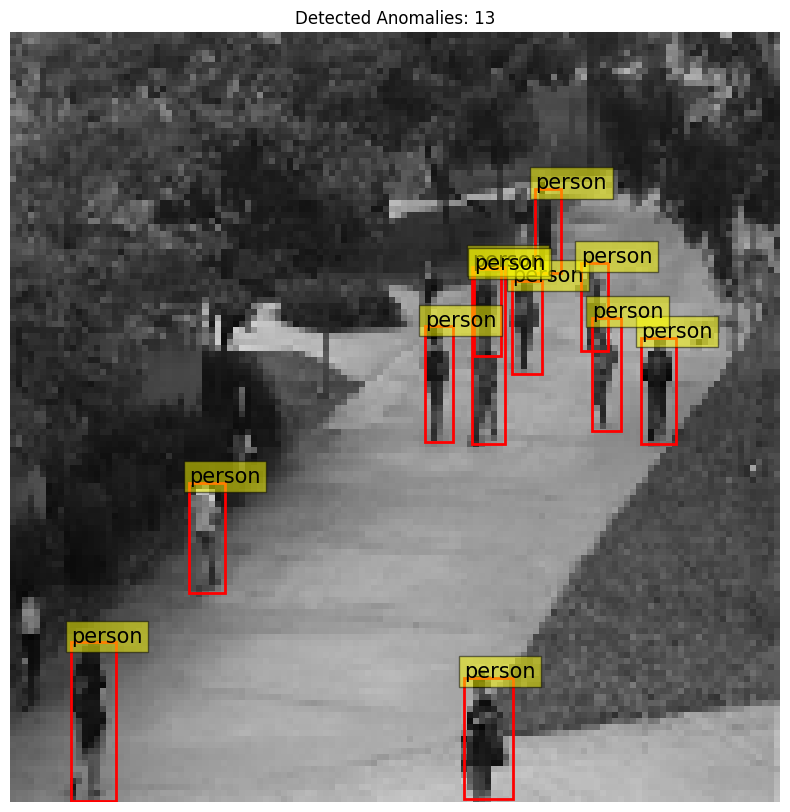

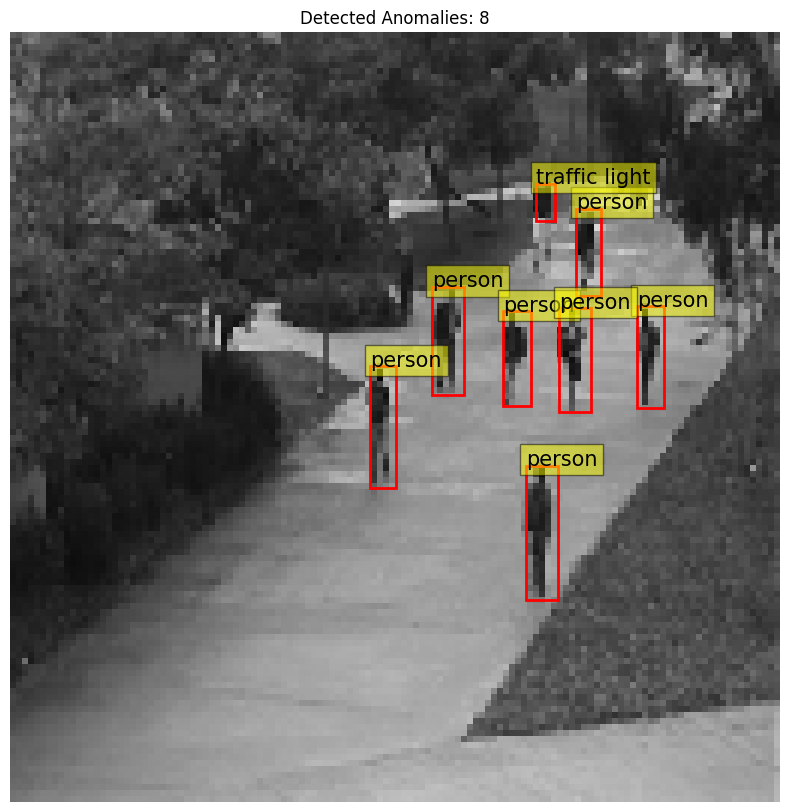

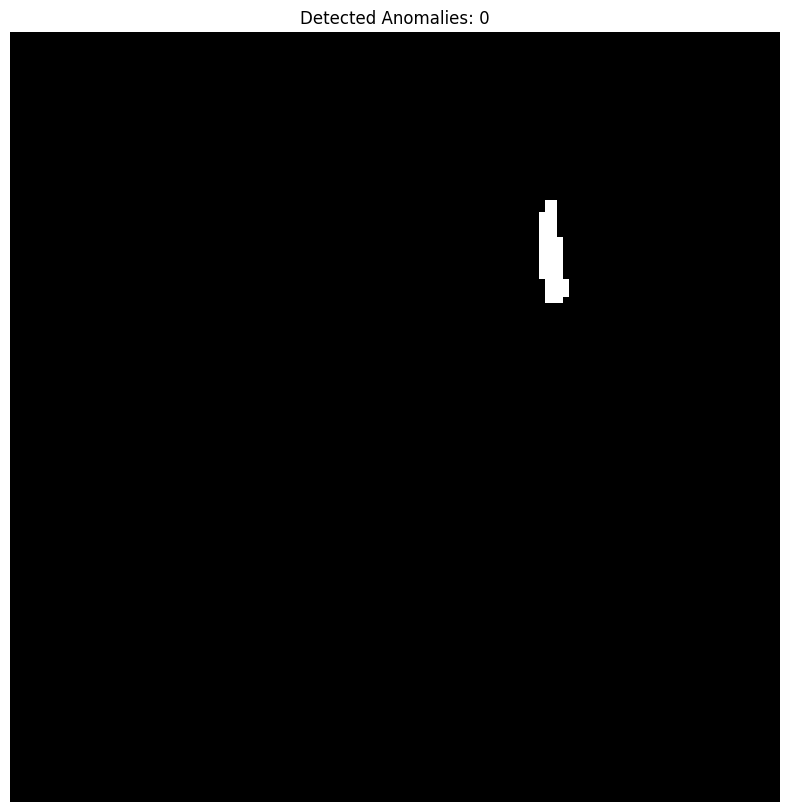

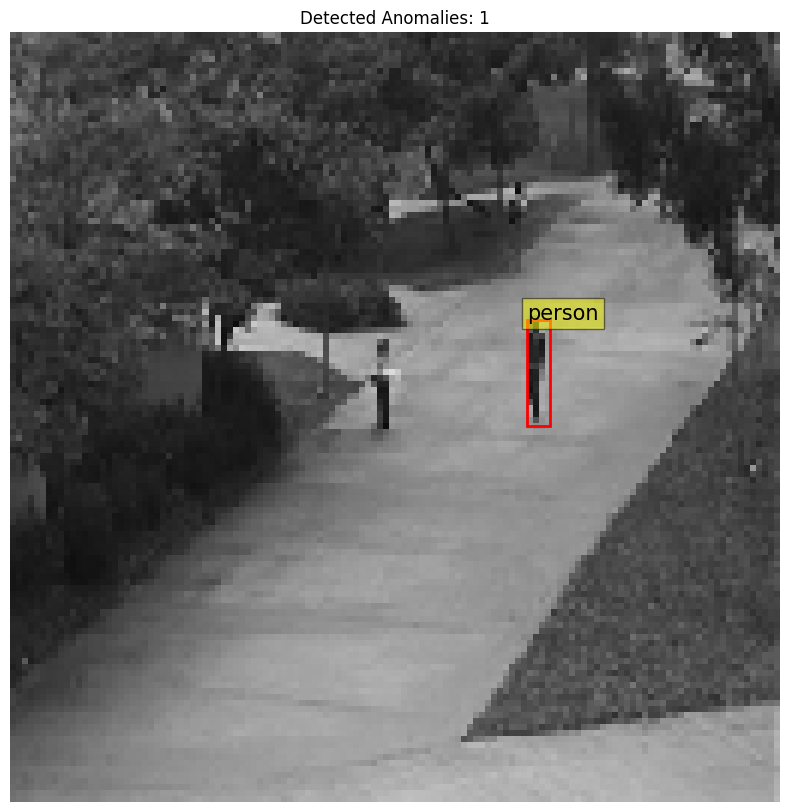

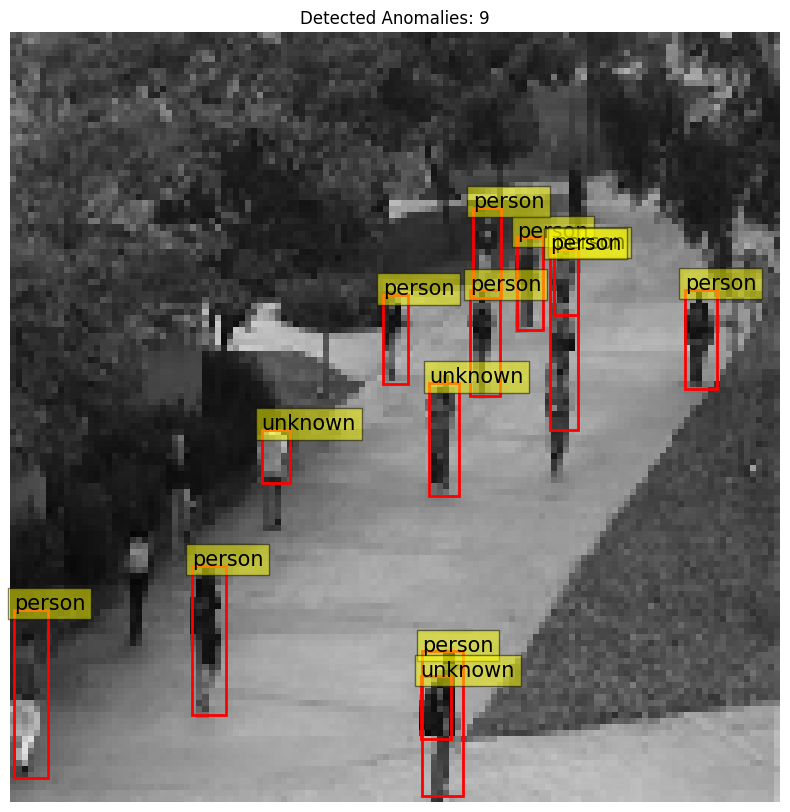

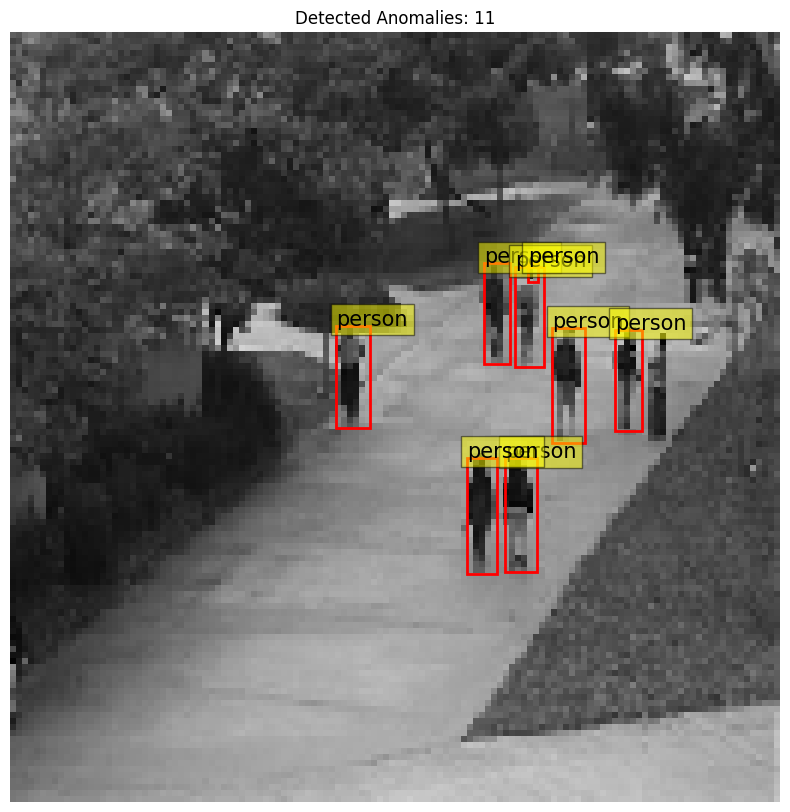

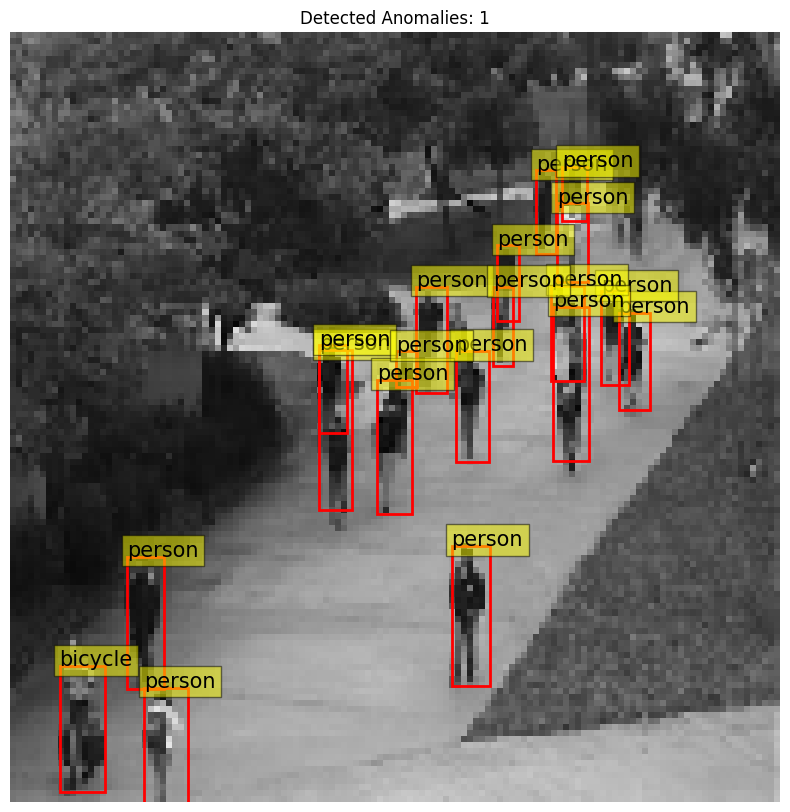

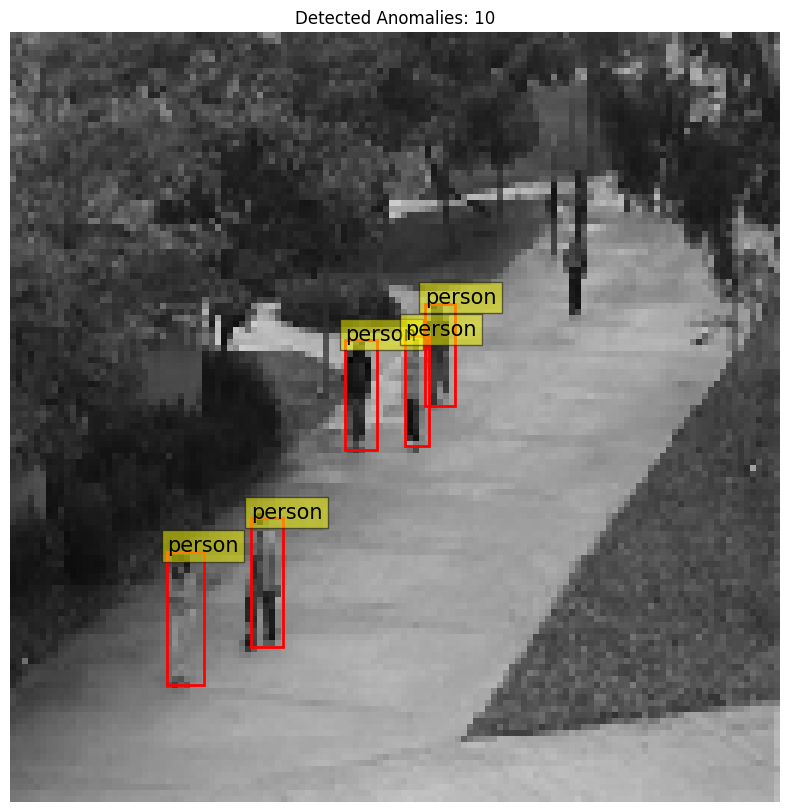

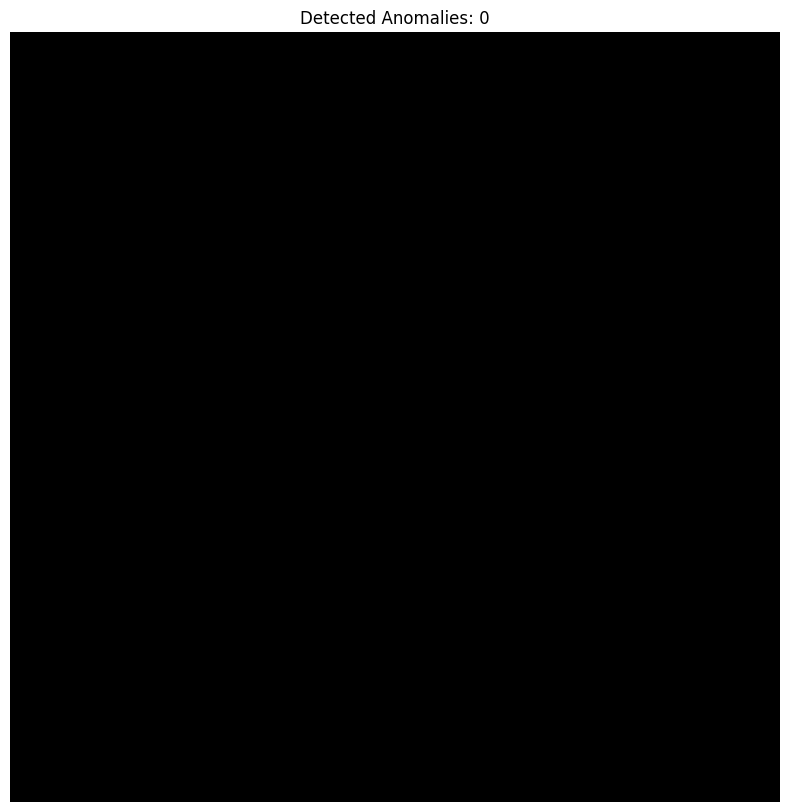

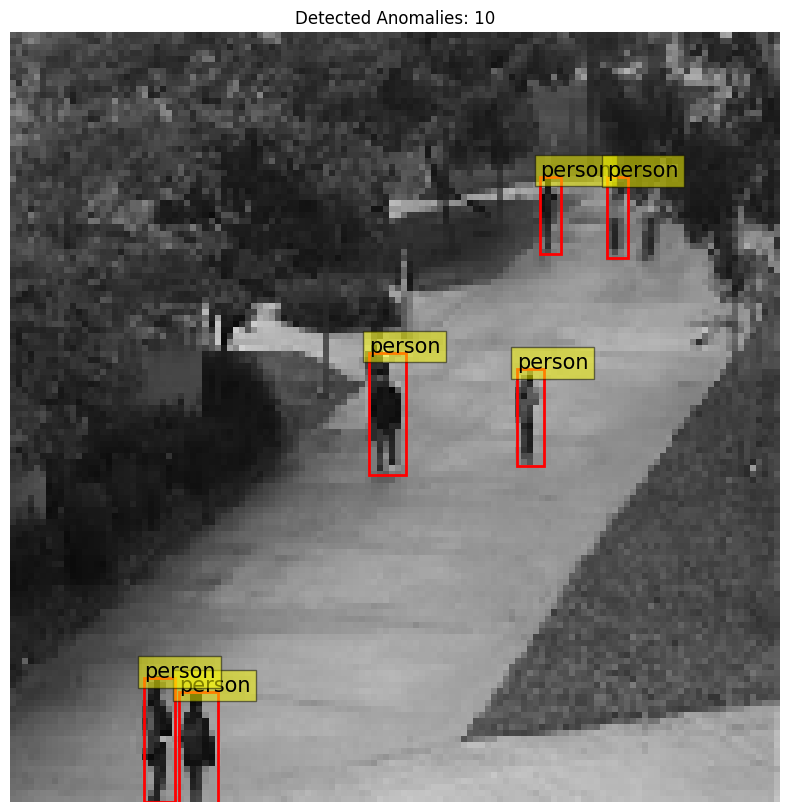

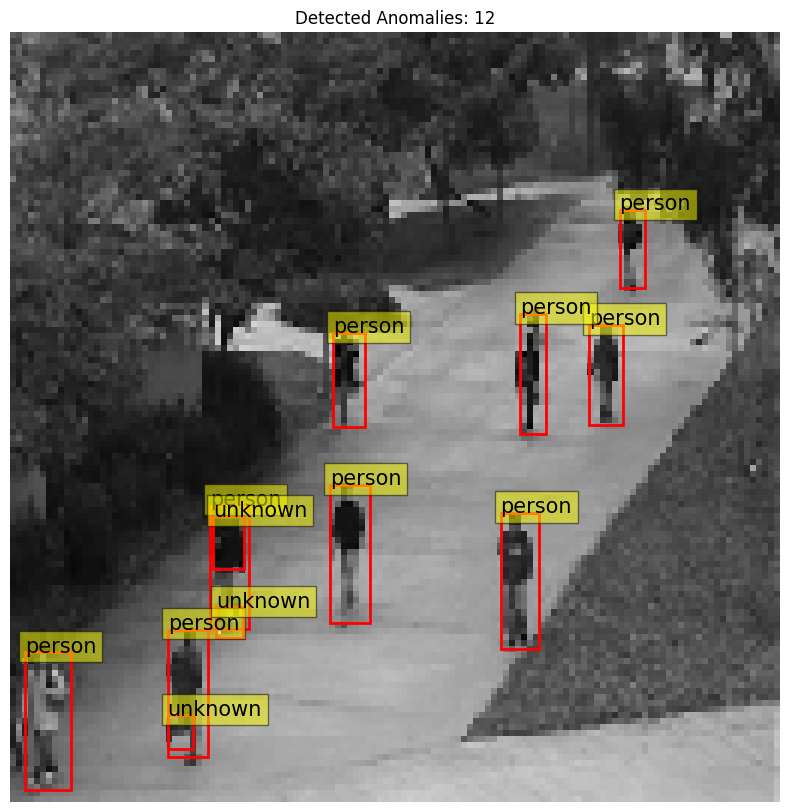

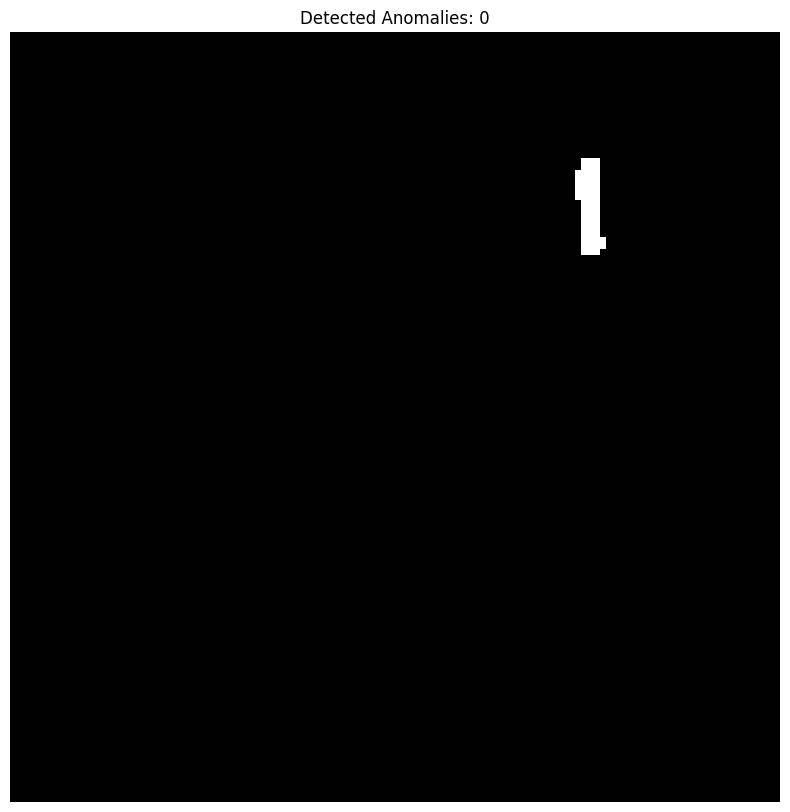

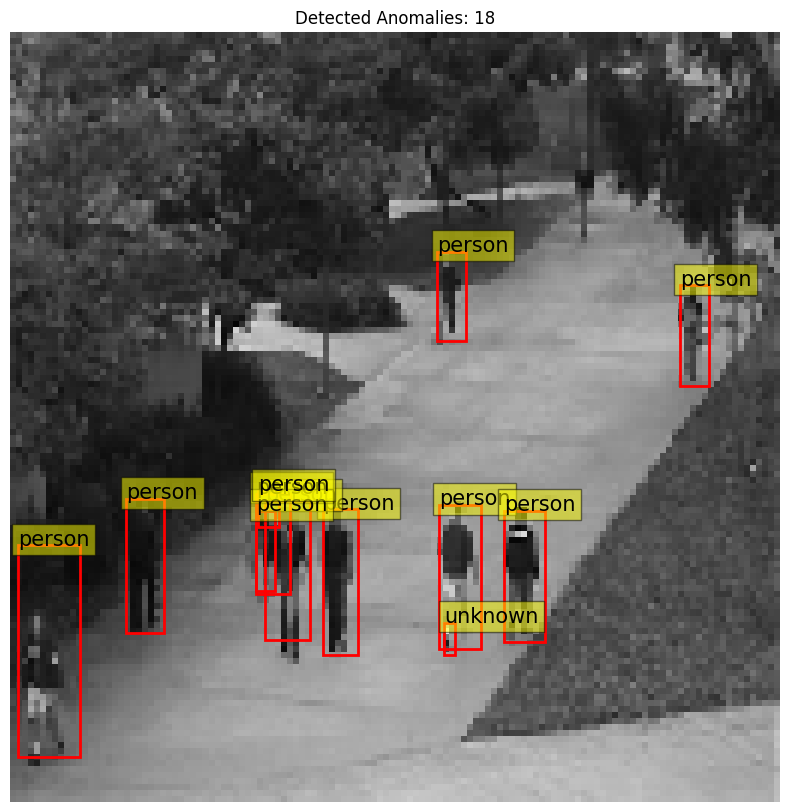

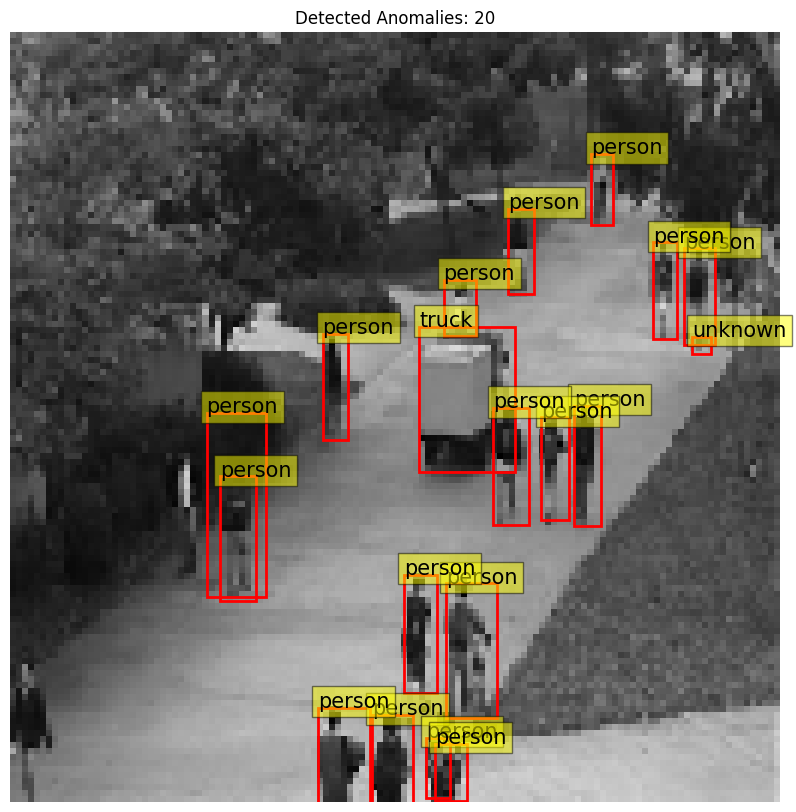

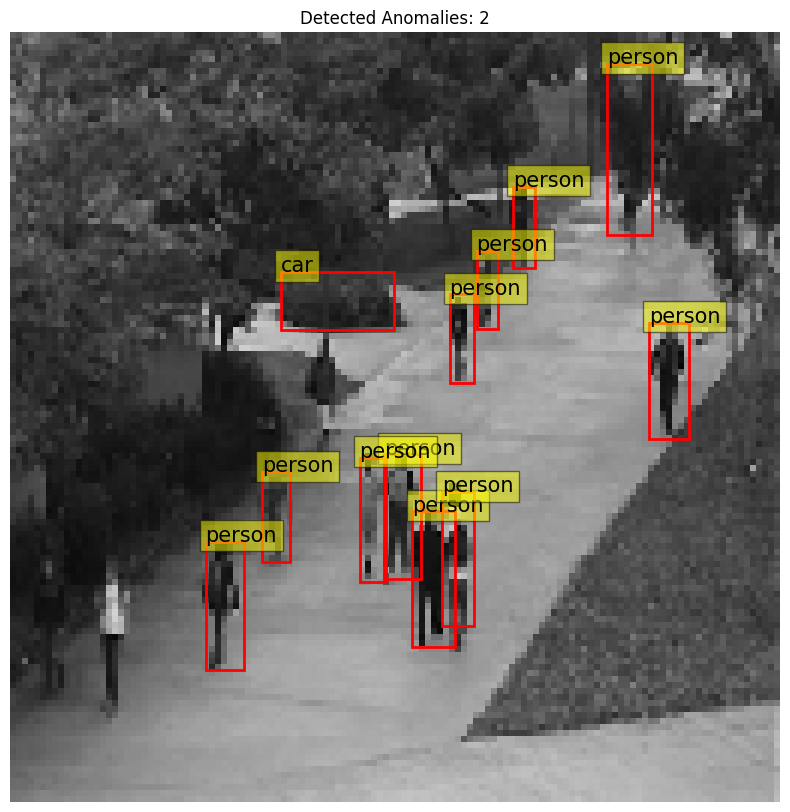

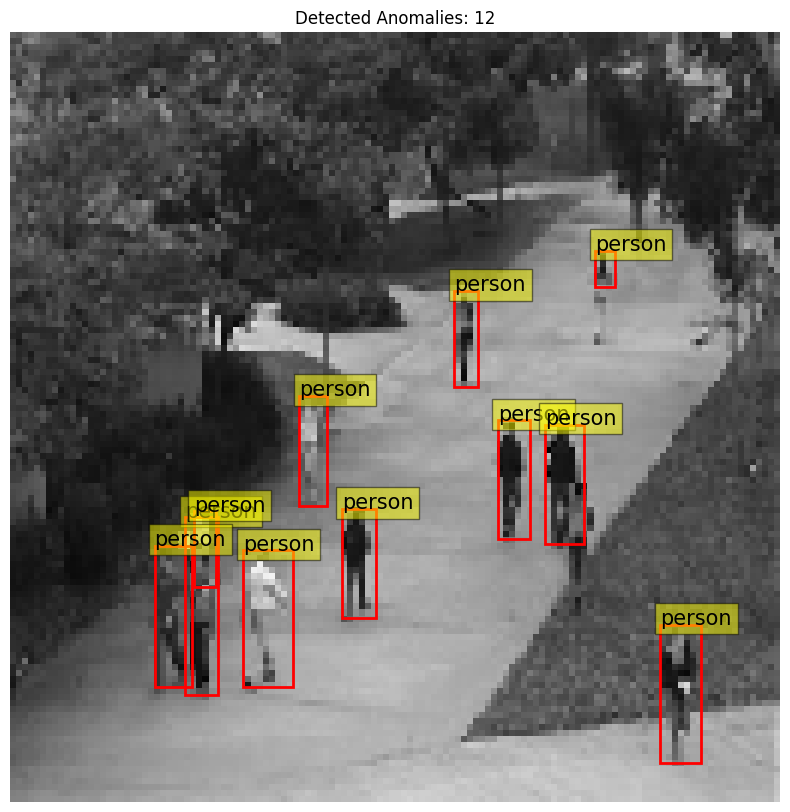

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

for i in range(len(X_test)):
  # Preprocessing for Faster R-CNN
  transform = transforms.Compose([
      transforms.ToTensor()
  ])

  # Load a sample image to perform object detection
  sample_image = Image.fromarray((X_test[i] * 255).astype(np.uint8))
  image_tensor = transform(sample_image).unsqueeze(0)  # Add batch dimension

  # Load pre-trained Faster R-CNN model
  model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  model.eval()

  # Perform object detection
  with torch.no_grad():
      predictions = model(image_tensor)

  # Extract bounding boxes and labels
  # predictions is a list with a single element because we are processing one image at a time
  boxes = predictions[0]['boxes']  # Access the first (and only) element
  labels = predictions[0]['labels']
  scores = predictions[0]['scores']

  # Filter out detections with low confidence
  confidence_threshold = 0.5
  filtered_indices = np.where(scores > confidence_threshold)[0]
  boxes = boxes[filtered_indices]
  labels = labels[filtered_indices]

  # Map COCO labels to names
  coco_labels = {1: 'person', 2: 'bicycle', 3: 'car', 8: 'truck', 10: 'traffic light', 12: 'stop sign', 16: 'dog', 18: 'cat'}
  detected_objects = [coco_labels.get(label.item(), 'unknown') for label in labels] # Handle unknown labels

  class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)  # Assuming input is 128x128 after pooling
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        if x.size(2) > 1 and x.size(3) > 1:  # Check if pooling is possible
            x = self.pool(x)
        x = F.relu(self.conv2(x))
        if x.size(2) > 1 and x.size(3) > 1:  # Check if pooling is possible
            x = self.pool(x)

        x = x.view(x.size(0), -1)
        self.fc1 = nn.Linear(x.size(1), 128)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

  class SimpleMLP(nn.Module):
      def __init__(self):
          super(SimpleMLP, self).__init__()
          self.fc2 = nn.Linear(128, 64)
          self.fc3 = nn.Linear(64, 2)  # Binary classification

      def forward(self, x):
          if not hasattr(self, 'fc1'):
              self.fc1 = nn.Linear(x.size(1), 128).to(x.device)  # Initialize fc1 dynamically based on input size
          x = F.relu(self.fc1(x))
          x = F.relu(self.fc2(x))
          x = self.fc3(x)
          return x

          # Dummy models for demonstration purposes (not trained)
  def classify_anomaly_with_cnn(cnn_model, image_tensor):
    with torch.no_grad():
        return cnn_model(image_tensor)

  def classify_anomaly_with_mlp(mlp_model, image_tensor):
    with torch.no_grad():
        batch_size = image_tensor.size(0)
        # Check the shape of image_tensor before flattening
        # print("Shape before flattening:", image_tensor.shape)
        image_tensor = image_tensor.view(batch_size, -1)  # Flatten the input
        # Check the shape after flattening
        # print("Shape after flattening:", image_tensor.shape)
        # Add resizing/padding to match the expected input size of the MLP
        image_tensor = F.interpolate(image_tensor.unsqueeze(1), size=432, mode='linear', align_corners=False).squeeze(1) # Resize the flattened tensor to 432
        return mlp_model(image_tensor)
  # Visualize results
  def visualize_detection(image, boxes, labels, title):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()
    for i, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = box
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red', linewidth=2)
        ax.add_patch(rect)
        label_name = coco_labels.get(labels[i].item(), 'unknown')  # Default to 'unknown' if label not found
        ax.text(xmin, ymin, label_name, fontsize=15, bbox=dict(facecolor='yellow', alpha=0.5))
    plt.title(title)
    plt.axis("off")
    plt.show()


  # Initialize the models
  cnn_model = CNNModel()
  mlp_model = SimpleMLP()

  detected_anomalies = 0
  for i, box in enumerate(boxes):
      xmin, ymin, xmax, ymax = box.round().int().tolist()  # Round and convert to integers
      cropped_region = sample_image.crop((xmin, ymin, xmax, ymax))
      cropped_tensor = transform(cropped_region).unsqueeze(0)

      # Detect anomaly using CNN
      cnn_output = classify_anomaly_with_cnn(cnn_model, cropped_tensor)
      if cnn_output.argmax(1).item() == 1:  # 1 indicates anomaly
          detected_anomalies += 1

      # Detect anomaly using MLP
      mlp_output = classify_anomaly_with_mlp(mlp_model, cropped_tensor)
      if mlp_output.argmax(1).item() == 1:  # 1 indicates anomaly
          detected_anomalies += 1

  visualize_detection(sample_image, boxes, labels, title=f"Detected Anomalies: {detected_anomalies}")